# Comparing TidalPy to Tobie+ (2005) and Roberts & Nimmo (2008)
RN08:  Roberts and Nimmo (2008; Icarus; DOI: 10.1016/j.icarus.2007.11.010)

TMS05: Tobie+ (2005; Icarus; DOI: 10.1016/j.icarus.2005.04.006)

Data points for both references were digitized from the plots presented in those papers.

## Matching Notes
To get a better match, we had to change:
- Tobie forcing Period to 0.9 Days
- There is a pretty large shift in the mantle for the Tobie comparison. If you decrease the shear modulus to 5.5e10 Pa then you get a much better match there, but then the radial displacement begins to have a shift. This along with the strange results of Tobie+ 2005 in the core makes us think that they ran into stability issues or perhaps changed values in-between plots. Or perhaps there is an error with TidalPy! Either way the match is not perfect.
- For Roberts & Nimmo, Have a good match when using propagation matrix technique, it is a bit off likely due to different starting conditions. Found the best fit for the core model using Eq. 1.150 from Sabadini+2016.

In [1]:
import numpy as np
import time
from TidalPy.constants import G
from TidalPy.utilities.conversions import orbital_motion2semi_a
from TidalPy.rheology import Maxwell, Elastic, Newton

# Load TidalPy's multilayer functions
from TidalPy.RadialSolver import radial_solver, build_rs_input_homogeneous_layers

# TODO Look at newton model in core

In [2]:
# Setup physical parameters and model switches

# Numerical settings
slice_per_layer = 50

# What should be plotted
show_shooting_method_technique       = False
show_propagation_matrix_technique    = True
nondimensionalize_during_integration = True
plot_tobie   = True
plot_roberts = True

# Physical and Orbital Properties
R_planet         = 1600.e3
bulk_density     = 3500.
planet_mass      = 1.08e20
host_mass        = 5.683e26
eccentricity     = 0.0045
viscosity_mantle = 1.e20
shear_mantle     = 6.68250e10
# shear_mantle     = 5.5e10
orbital_freq_HZ  = 5.308e-5  
# This is reported as Hz in RN08. But it is really rad s-1 if you compare the values to the target of 1.37 days for Enceladus orbital period.

orbital_freq_TB_match = 2. * np.pi / (86400. * 0.9)
freq_europa = 2.04793e-05
freq_titan  = 4.55938e-06

# orbital_freq = orbital_freq_HZ  # Do not get a good match when using values reported.
orbital_freq = orbital_freq_TB_match

semi_major_axis = orbital_motion2semi_a(orbital_freq, host_mass, planet_mass)

# From RN08 "Rigidity and viscosity have been reduced by a factor of 1e6 and 1e9 respectively from the overlying ice shell"
viscosity_core = 1.e13 / 1.e9
# shear_core = 4.e9 / 1.e6
shear_core = 0.

# Density of core varies with the different models used.
density_no_core        = None
density_core_1         = 5150.0
density_core_2         = 8000.0
mantle_density_no_core = 3500.
mantle_density_core_1  = 3300.
mantle_density_core_2  = 3300.
density_models = {
"Homogeneous": (density_no_core, mantle_density_no_core),
"Core 1":      (density_core_1, mantle_density_core_1),
"Core 2":      (density_core_2, mantle_density_core_2)
}

# There are various switches that must be turned to match one model vs. the other.
# TidalPy does a decent job of matching both but requires slightly different inputs
use_kamata_starting_values    = {'TidalPy-Tobie' : False, 'TidalPy-Roberts' : True}
orbital_freq_dict             = {'TidalPy-Tobie' : orbital_freq_TB_match, 'TidalPy-Roberts' : orbital_freq_HZ}
use_static_mantle             = {'TidalPy-Tobie' : False, 'TidalPy-Roberts' : False}
use_static_liquid_core        = {'TidalPy-Tobie' : False, 'TidalPy-Roberts' : True}
use_fake_incompressible_limit = {'TidalPy-Tobie' : False, 'TidalPy-Roberts' : True}
use_real_incompressible_limit = {'TidalPy-Tobie' : False, 'TidalPy-Roberts' : True}

# Radial Solver common arguments and options
other_rs_inputs_common = dict(
    surface_pressure         = 0.0,
    degree_l                 = 2,
    solve_for                = ('tidal',),
    core_model               = 0,
    use_kamata               = True,
    starting_radius          = 0.1,
    start_radius_tolerance   = 1.0e-5,
    integration_method       = 'RK45',
    integration_rtol         = 1.0e-8,
    integration_atol         = 1.0e-12,
    scale_rtols_bylayer_type = False,
    max_num_steps            = 1_500_000,
    expected_size            = 1000,
    max_ram_MB               = 4000,
    max_step                 = 0,
    nondimensionalize        = nondimensionalize_during_integration,
    use_prop_matrix          = False,
    verbose                  = False,
    warnings                 = False,
    raise_on_fail            = False,
    eos_method_bylayer       = None,
    eos_integration_method   = 'DOP853',
    eos_rtol                 = 1.0e-8,
    eos_atol                 = 1.0e-14,
    eos_pressure_tol         = 1.0e-2,
    eos_max_iters            = 350,
    perform_checks           = True,
    log_info                 = False
)

In [3]:
# Setup 3 models based on the three layer structures used in Tobie 2005
model_radii   = dict()
model_results = dict()
model_colors  = dict()
model_ls      = dict()

comparisons = list()
add_names   = list()
colors      = list()
ls          = list()
if show_propagation_matrix_technique:
    comparisons.append('TidalPy-Roberts')
    add_names.append('-PropMat')
    colors.append('green')
    ls.append('--')
    comparisons.append('TidalPy-Tobie')
    add_names.append('-PropMat')
    colors.append('green')
    ls.append('-')
if show_shooting_method_technique:
    comparisons.append('TidalPy-Roberts')
    add_names.append('')
    colors.append('k')
    ls.append('--')
    comparisons.append('TidalPy-Tobie')
    add_names.append('')
    colors.append('k')
    ls.append('-')

for c_i, comparison_name in enumerate(comparisons):
    for model_name, (core_density, mantle_density) in density_models.items():

        run_name = f"{comparison_name}{add_names[c_i]} ({model_name})"
        
        has_core = True
        if core_density is None:
            has_core = False

        use_prop_matrix = False
        jump_to_core = False
        if "PropMat" in run_name:
            use_prop_matrix = True
            
        if has_core and use_prop_matrix:
            # Propagation Matrix only works for single layers right now.
            jump_to_core = True
            # print(f'Skipping model {run_name}.')
            # continue

        if model_name == 'Core 2' and comparison_name == 'TidalPy-Roberts':
            # There is no second core model to compare against for Roberts
            continue
        if model_name == 'Core 2' and use_prop_matrix:
            # There is no second core model to compare against for Roberts
            continue
            

        print(f'Working on model {run_name}.')
        t0 = time.time()

        if use_fake_incompressible_limit[comparison_name]:
            bulk_mantle = 1.e15
            bulk_core = 1.e15
        else:
            bulk_mantle = 1.2210e11
            bulk_core = 2.88e11
        
        # Determine the radius structure and layer assumptions
        R_core = None
        if has_core:
            R_core = ((bulk_density - mantle_density) / (core_density - mantle_density))**(1 / 3) * R_planet

        if has_core and not jump_to_core:
            density_tuple                 = (core_density, mantle_density)
            static_bulk_modulus_tuple     = (bulk_core, bulk_mantle)
            static_shear_modulus_tuple    = (shear_core, shear_mantle)
            bulk_viscosity_tuple          = (1.0e30, 1.0e30)  # Unused in this comparison
            shear_viscosity_tuple         = (viscosity_core, viscosity_mantle)
            layer_type_tuple              = ('liquid', 'solid')
            layer_is_static_tuple         = (use_static_liquid_core[comparison_name], use_static_mantle[comparison_name])
            layer_is_incompressible_tuple = (use_real_incompressible_limit[comparison_name], use_real_incompressible_limit[comparison_name])
            shear_rheology_model_tuple    = (Maxwell(), Maxwell())
            bulk_rheology_model_tuple     = (Elastic(), Elastic())
            radius_fraction_tuple         = (R_core/R_planet, R_planet/R_planet)
        else:
            density_tuple                 = (mantle_density,)
            static_bulk_modulus_tuple     = (bulk_mantle,)
            static_shear_modulus_tuple    = (shear_mantle,)
            bulk_viscosity_tuple          = (1.0e30,)  # Unused in this comparison
            shear_viscosity_tuple         = (viscosity_mantle,)
            layer_type_tuple              = ('solid',)
            layer_is_static_tuple         = (use_static_mantle[comparison_name],)
            layer_is_incompressible_tuple = (use_real_incompressible_limit[comparison_name],)
            shear_rheology_model_tuple    = (Maxwell(),)
            bulk_rheology_model_tuple     = (Elastic(),)
            radius_fraction_tuple         = (R_planet/R_planet,)

            if use_prop_matrix:
                layer_is_static_tuple = (True,)
                layer_is_incompressible_tuple = (True,)

        # Build RS Inputs
        slice_per_layer_to_use = slice_per_layer
        if jump_to_core:
            slice_per_layer_to_use *= 2
            
        rs_input = build_rs_input_homogeneous_layers(
            R_planet,
            orbital_freq_dict[comparison_name],
            density_tuple,
            static_bulk_modulus_tuple,
            static_shear_modulus_tuple,
            bulk_viscosity_tuple,
            shear_viscosity_tuple,
            layer_type_tuple,
            layer_is_static_tuple,
            layer_is_incompressible_tuple,
            shear_rheology_model_tuple,
            bulk_rheology_model_tuple,
            radius_fraction_tuple=radius_fraction_tuple,
            slice_per_layer=slice_per_layer_to_use,
            perform_checks=True
        )

        # Adjust other inputs based off a copy of the common inputs
        rs_other_inputs = {**other_rs_inputs_common}
        rs_other_inputs['use_prop_matrix'] = use_prop_matrix
        rs_other_inputs['use_kamata']      = use_kamata_starting_values[comparison_name]
        if jump_to_core:
            rs_other_inputs['starting_radius'] = R_core
            rs_other_inputs['core_model'] = 5
            
        # Run TidalPy's Radial Solver
        radial_solution = radial_solver(
            *rs_input,
            **rs_other_inputs
        )

        # Parse and save results
        if not radial_solution.success:
            print("Radial Solver Failed.")
        else:
            model_radii[run_name]  = radial_solution.radius_array
            model_results[run_name]  = radial_solution.result
            model_colors[run_name] = colors[c_i]
            model_ls[run_name]     = ls[c_i]

        # Clean up core results for Roberts
        if run_name == 'TidalPy-Roberts (Core 1)':
            model_results[run_name][:, rs_input.radius_array <= R_core] = np.nan

        print(f'Model {model_name} Completed!. Taking {time.time() - t0:0.6f}s\n------------------\n')

Working on model TidalPy-Roberts-PropMat (Homogeneous).
Model Homogeneous Completed!. Taking 0.000000s
------------------

Working on model TidalPy-Roberts-PropMat (Core 1).
Model Core 1 Completed!. Taking 0.000000s
------------------

Working on model TidalPy-Tobie-PropMat (Homogeneous).
Model Homogeneous Completed!. Taking 0.000000s
------------------

Working on model TidalPy-Tobie-PropMat (Core 1).
Model Core 1 Completed!. Taking 0.000000s
------------------



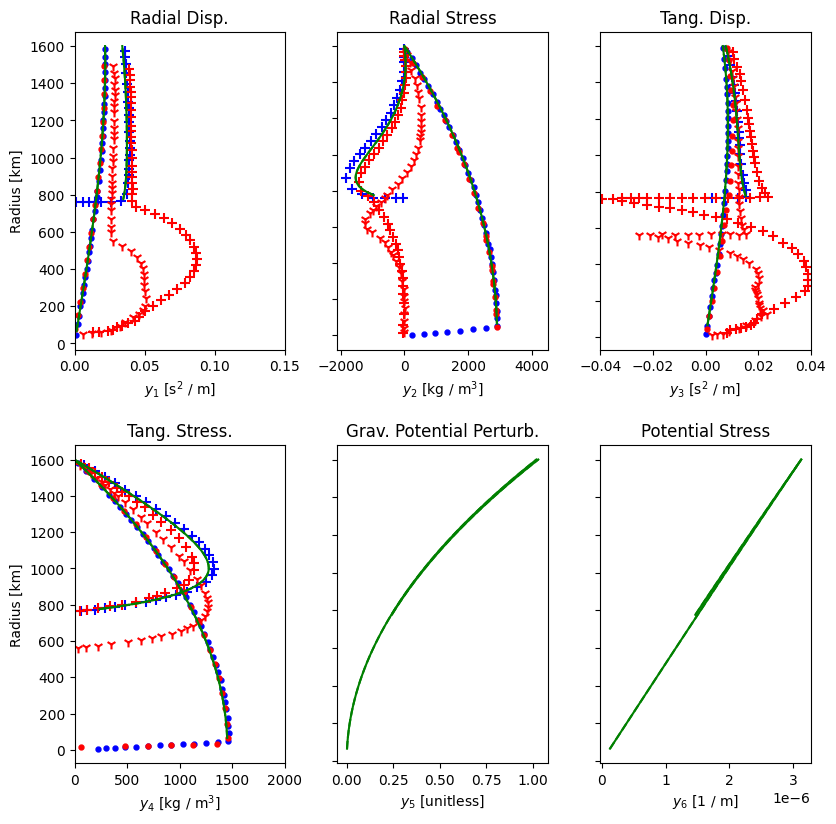

In [4]:
# Plot Results - Full Domain
from TidalPy.utilities.graphics.multilayer import yplot
fig, axes = yplot(
    list(model_results.values()),
    list(model_radii.values()),
    labels=list(model_results.keys()),
    colors=list(model_colors.values()),
    line_styles=list(model_ls.values()),
    use_tobie_limits=True,
    plot_tobie=plot_tobie,
    plot_roberts=plot_roberts,
    show_plot=False)

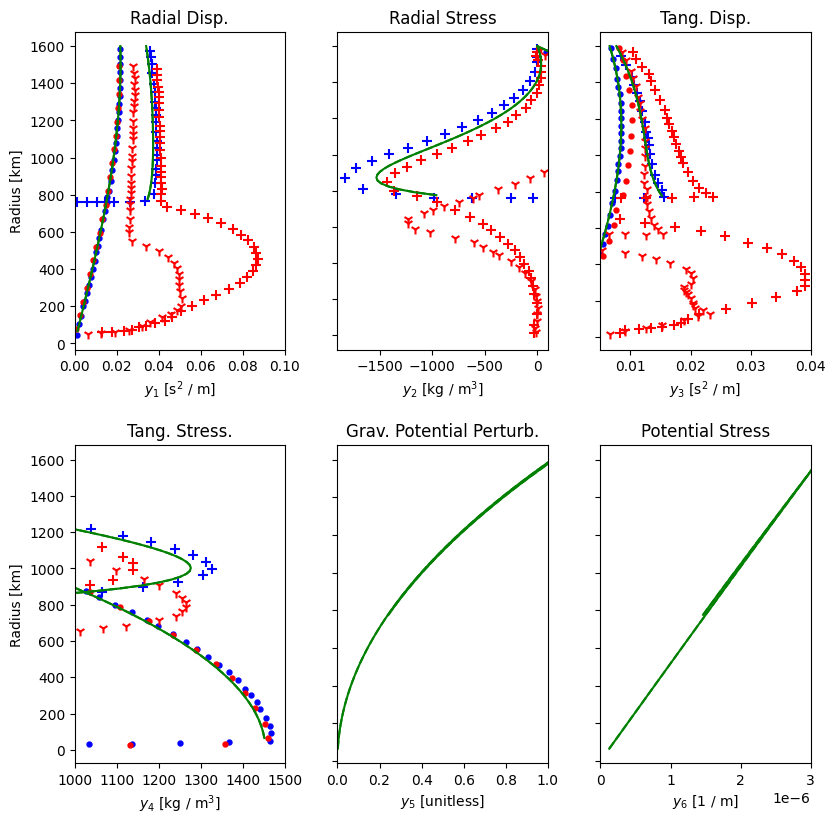

In [5]:
# Plot Results - Zoomed in
other_xlimits = [radial_solution
    (0.0, 0.1),
    (-1900, 100),
    (0.005, 0.04),
    (1000.0, 1500.),
    (0.0, 1.0),
    (0.0, 3.0e-6)
]

fig, axes = yplot(
    list(model_results.values()),
    list(model_radii.values()),
    labels=list(model_results.keys()),
    colors=list(model_colors.values()),
    line_styles=list(model_ls.values()),
    use_tobie_limits=False,
    plot_tobie=plot_tobie,
    plot_roberts=plot_roberts,
    show_plot=False,
    other_xlimits=other_xlimits,
    )